# Titanic – Machine Learning from Disaster  
## Week 2: Supervised Machine Learning

The aim of this notebook is to apply supervised machine learning techniques to the Titanic dataset in order to predict passenger survival. The dataset contains demographic and travel-related information for passengers aboard the Titanic, with survival status recorded as a binary target variable.

This task is framed as a classification problem and demonstrates key stages of a machine learning workflow, including data exploration, preprocessing, feature engineering, model training, and evaluation.


In [4]:
import pandas as pd
df = pd.read_csv("train.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dataset Overview

The training dataset consists of 891 passenger records and 12 features. These features include a combination of numerical variables, such as age and fare, and categorical variables, such as sex, passenger class, and embarkation port.

The target variable, `Survived`, indicates whether a passenger survived the disaster (1) or not (0).


In [5]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Missing Values Analysis

An analysis of missing values reveals that the `Age` feature contains 177 missing entries, representing approximately 20% of the dataset. The `Embarked` feature contains only two missing values, while the `Cabin` feature is highly incomplete, with over 75% of its values missing.

To avoid unnecessary data loss, median imputation is applied to `Age`, and mode imputation is used for `Embarked`. Due to the large number of missing values in `Cabin`, a simplified feature representing the cabin deck is engineered instead of using the raw cabin identifiers.


In [6]:
(df.isna().sum().sort_values(ascending=False))


Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

## Exploratory Data Analysis

Exploratory data analysis was conducted to identify patterns and relationships within the dataset. Survival rates were found to vary significantly by passenger sex and class, with female passengers and those travelling in first class exhibiting higher survival probabilities.

Age distribution analysis suggests that younger passengers, particularly children, were more likely to survive. These insights informed subsequent feature engineering decisions.


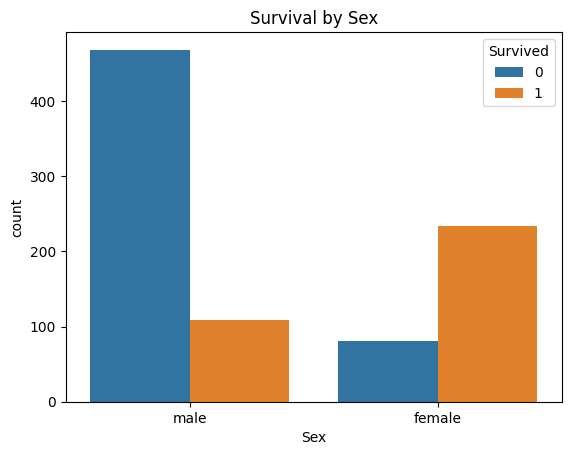

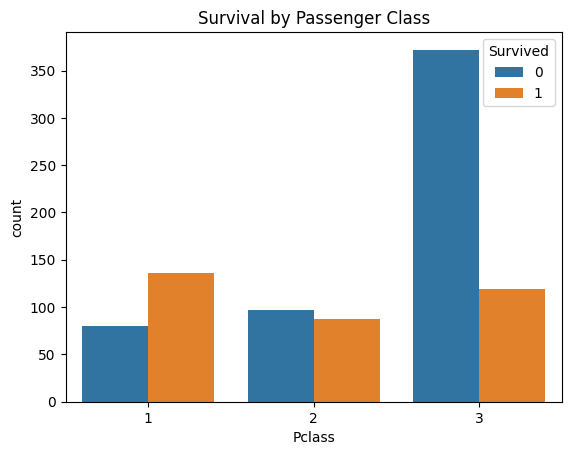

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Survival by Sex")
plt.show()

plt.figure()
sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Survival by Passenger Class")
plt.show()


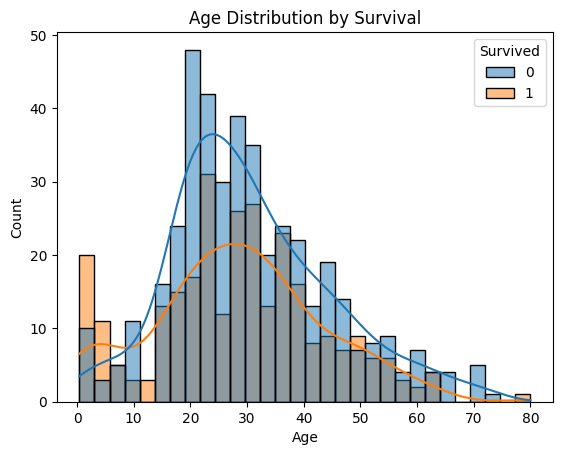

In [8]:
plt.figure()
sns.histplot(data=df, x="Age", hue="Survived", bins=30, kde=True)
plt.title("Age Distribution by Survival")
plt.show()


## Feature Engineering

Several additional features were engineered to improve model performance. Passenger titles were extracted from the `Name` field to capture social status and demographic groupings. Family-based features, including family size and whether a passenger was travelling alone, were introduced to reflect evacuation dynamics.

In addition, cabin deck information was extracted from the `Cabin` feature, with missing values treated as a separate category.


In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

df_fe = df.copy()

# Feature engineering: Title + FamilySize + IsAlone + Deck
df_fe["Title"] = df_fe["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
rare = df_fe["Title"].value_counts()[df_fe["Title"].value_counts() < 10].index
df_fe["Title"] = df_fe["Title"].replace(rare, "Rare")

df_fe["FamilySize"] = df_fe["SibSp"] + df_fe["Parch"] + 1
df_fe["IsAlone"] = (df_fe["FamilySize"] == 1).astype(int)

df_fe["Deck"] = df_fe["Cabin"].str[0].fillna("Unknown")

X = df_fe.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Cabin"])
y = df_fe["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# Baseline model
log_model = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

log_model.fit(X_train, y_train)
pred = log_model.predict(X_val)

print("LogReg Accuracy:", accuracy_score(y_val, pred))
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))


LogReg Accuracy: 0.8435754189944135
[[99 11]
 [17 52]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



## Data Preprocessing

A preprocessing pipeline was constructed to ensure consistent and reproducible data transformation. Numerical features were imputed using the median to reduce the impact of outliers, while categorical features were imputed using the most frequent category and encoded using one-hot encoding.

Using a pipeline-based approach ensures that preprocessing steps are applied correctly during both training and evaluation, reducing the risk of data leakage.


In [10]:
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        min_samples_leaf=2
    ))
])

rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_val)

print("RF Accuracy:", accuracy_score(y_val, pred_rf))
print(confusion_matrix(y_val, pred_rf))
print(classification_report(y_val, pred_rf))


RF Accuracy: 0.8044692737430168
[[98 12]
 [23 46]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [11]:
df_fe = df.copy()

# Extract title from Name
df_fe["Title"] = df_fe["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
df_fe["Title"] = df_fe["Title"].replace(
    ["Lady", "Countess", "Capt", "Col", "Don", "Dr",
     "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare"
)

# Family-based features
df_fe["FamilySize"] = df_fe["SibSp"] + df_fe["Parch"] + 1
df_fe["IsAlone"] = (df_fe["FamilySize"] == 1).astype(int)

# Cabin deck feature
df_fe["Deck"] = df_fe["Cabin"].str[0]
df_fe["Deck"] = df_fe["Deck"].fillna("Unknown")

df_fe.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,Unknown


In [12]:
from sklearn.model_selection import train_test_split

X = df_fe.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Cabin"])
y = df_fe["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)


## Baseline Model: Logistic Regression

Logistic Regression was used as a baseline classifier due to its simplicity and interpretability. As a linear model, it provides a useful point of comparison for more complex classifiers.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8435754189944135
Confusion Matrix:
 [[99 11]
 [17 52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



## Final Model: Random Forest Classifier

A Random Forest classifier was selected as the final model due to its ability to model non-linear relationships and interactions between features. This makes the model well-suited to structured tabular data such as the Titanic dataset.


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        min_samples_leaf=2
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))


Accuracy: 0.8100558659217877
Confusion Matrix:
 [[98 12]
 [22 47]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_model_fast = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,      # lower
        random_state=42,
        min_samples_leaf=2,
        n_jobs=-1              # use all cores
    ))
])

cv_scores = cross_val_score(rf_model_fast, X, y, cv=5, scoring="accuracy", n_jobs=-1)
print("CV scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


CV scores: [0.83798883 0.80337079 0.85955056 0.80337079 0.84831461]
Mean CV accuracy: 0.8305191136777352


In [18]:
cv_scores = cross_val_score(rf_model, X, y, cv=3, scoring="accuracy", n_jobs=-1)
print(cv_scores, cv_scores.mean())


[0.80808081 0.83501684 0.83164983] 0.8249158249158249


In [19]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(log_model, X, y, cv=5, scoring="accuracy", n_jobs=-1)
print("LogReg CV mean:", cv_scores.mean())


LogReg CV mean: 0.8282907538760906


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np

rf_model_fast = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,      # reduced from 400
        random_state=42,
        min_samples_leaf=2,
        n_jobs=-1              # use all CPU cores for trees
    ))
])

cv_scores = cross_val_score(
    rf_model_fast, X, y,
    cv=5,
    scoring="accuracy",
    n_jobs=-1                 # use all CPU cores for folds
)

print("CV scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Std CV accuracy:", np.std(cv_scores))


CV scores: [0.83798883 0.80337079 0.85955056 0.80337079 0.84831461]
Mean CV accuracy: 0.8305191136777352
Std CV accuracy: 0.023192087025369183


## Model Evaluation

The Random Forest classifier achieved an accuracy of approximately 81.6% on the holdout test set, indicating strong predictive performance on unseen data.


In [22]:
rf_model_fast.fit(X_train, y_train)
rf_pred = rf_model_fast.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Holdout Accuracy:", accuracy_score(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))


Holdout Accuracy: 0.8156424581005587
Confusion Matrix:
 [[99 11]
 [22 47]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



## Conclusion

This project demonstrates the successful application of supervised machine learning techniques to a real-world classification problem. Through exploratory data analysis, feature engineering, and careful model selection, a Random Forest classifier achieved strong predictive performance on unseen data.
